### 二元配置分散分析 Two-way ANOVA

#### インポート パッケージ　Import packages

In [46]:
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt

import statsmodels.api as sm
# Regression with a formula 
from statsmodels.formula.api import ols
# For multiple comparison
import statsmodels.stats.multicomp as mlpc
# Plot interaction 
from statsmodels.graphics.factorplots import interaction_plot

from IPython.core.display import display

#### データファイルを読み込む Read the data file

In [47]:
# Loading data
data_frame = pd.read_csv("data/prob9.csv", delimiter=",")

# ## split data
# 1.  find all levels
race_levels = pd.unique(data_frame['race'])
activity_levels = pd.unique(data_frame['activity'])
# 2. extract data
data = []
combi_levels =[]
for race in race_levels:
    for activity in activity_levels:
        combi_levels.append((race, activity))
        d_temp = data_frame[(data_frame["race"]==race) & (data_frame['activity'] == activity)]['bmi']
        data.append(d_temp.tolist())
print(combi_levels)
print(data)    

[(2, 3), (2, 1), (2, 2), (1, 3), (1, 1), (1, 2)]
[[21.782961910999997, 21.317268531, 24.145903626, 29.301699173000003, 20.767809429, 35.787267053, 19.847376973, 20.759197711, 25.04295223, 20.474603332, 32.736011714, 29.021773453, 25.237227645999997, 26.008325028, 30.047389025, 18.568826563, 30.552437061, 33.733784761, 25.076208448000003, 23.939457188000002, 19.921785409, 27.832912043, 23.218145134, 29.698613514, 36.37945605, 22.106064861999997, 25.132923488000003, 24.43140492, 21.20258708, 27.209960518000003, 23.148989154000002, 33.936199944, 33.391818111, 18.299328225, 20.549088279, 21.519391383000002, 35.610181841, 21.904928569000003, 30.650120909, 17.334735311, 22.565406620999998, 20.911212431, 28.144182948, 27.521028865, 21.84823083, 19.033072879000002, 24.541562693000003, 36.569637781, 22.977909298, 17.870092466, 20.065437284, 21.92175951, 20.009631487, 23.447163294, 21.099400569, 31.870358443, 21.477656176999997, 21.998680963, 28.956986888000003, 20.989040842999998, 17.92201336, 

#### 3つ前提　Three Assumptions 
1. 外れ値があるかどうか（ある場合、合理的な理由があれば、削除することが可能です）  
2. 等分散性検定（ここで、levene's testを使えます）   
3. 群間に従属変数の正規性検定（Shapiro-Wilk検定、ここに触らない）


1. No outliers (if you have outliers, e.g., you may delete it for any reasonable reason )
2. Homogeneity of variance (Here, we use levene's test)
3. The dependent variable is normally distributed across the groups (Shapiro-Wilk test, not touched in this lecture)

###### 1. 外れ値を検知する　Detect outliers

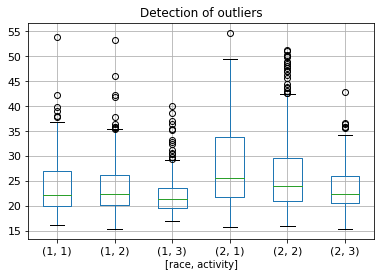

In [48]:
boxplot = data_frame.boxplot(column=['bmi'], by=['race', 'activity'], fontsize="11", figsize=(6,4))
# Add a title for the figure
plt.title("Detection of outliers")
# Remove the automatically generated title
plt.suptitle("")
plt.show()

###### 2. 等分散性検定 　Test of homogeneity of Variance
**Levene's test**:  
F検定を用いて、グループ間で分散が等しいという帰無仮説を検証します.  
ここで、0.05未満のp値は、帰無仮説を棄却します。
帰無仮説を棄却する場合は、ノンパラメトリック方法で検定するのが適切です。

**Levene's test**:  
It uses an F-test to test the null hypothesis that the variance is equal across groups.   
Here, a p value less than .05 indicates a violation of the assumption.  
If a violation occurs, it is likely that conducting the non-parametric equivalent of the analysis is more appropriate.

## scipy's levene()

W, p_value = [scipy.stats.levene](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.levene.html)(\*args, \*\*kwds)

```python
"""
Parameters:  

sample1, sample2, ... : array_like  
    サンプルデータ、長さが異なることも可能。  
    The sample data, possibly with different lengths  
center: {‘mean’, ‘median’, ‘trimmed’}, optional  
    検定に使う関数。デフォルトは 'median'。  
    Which function of the data to use in the test. The default is ‘median’.  
proportiontocut : float, optional  
       centerが'trimmed'とき、これは各端から切り取るデータ点の割合を与える。デフォルトは0.05.
        When center is ‘trimmed’, this gives the proportion of data points to cut from each end. 
        (See scipy.stats.trim_mean.)  The default is 0.05.  

Returns:

  W: float  
       検定統計量  
       The test statistic.  
       
  p-value : float  
  　　 p値  
       The p-value for the test.
 """
 ```
 

In [49]:
# Levene's test and Barlett test: the number of replications is not SAME
w, pval_homo_var = ss.levene(data[0], data[1], data[2], data[3], data[4], data[5], center="median")
if pval_homo_var > 0.05:
    print("Retain H0 and the variance is equal across groups")
else:
    print("Reject H0. It is likely that conducting the non-parametric equivalent of the analysis is more appropriate.")

Reject H0. It is likely that conducting the non-parametric equivalent of the analysis is more appropriate.


In [50]:
# Calculate effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/ \
             (sum(aov['sum_sq'])+aov['mean_sq'][-1])
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

#### 交互作用 interaction

In [51]:
### ---- using statsmodels ---- ###
# 1. interaction
f = 'bmi ~ C(race) * C(activity)'
model = ols(formula=f, data=data_frame)

# 2. regression
result = model.fit()
print("Overall model F({:.0f},{:.0f}) = {:.3f}, p = {:.4f}".format(result.df_model, result.df_resid, result.fvalue, result.f_pvalue))
# or 
#print(result.summary())

# 3. anova_lm()による二元配置分散分析 Conduct a two-way ANOVA by anova_lm()
anova_tbl = sm.stats.anova_lm(result, typ=2)
print(anova_tbl)
print("Two-way ANOVA table:")
display(anova_table(anova_tbl))
pval_inter = anova_tbl.at["C(race):C(activity)", "PR(>F)"]
if pval_inter < 0.05:
    print("The interaction term is significant.") 
else:
    print("The interaction term is not significant.") 

Overall model F(5,1865) = 37.690, p = 0.0000
                           sum_sq      df          F        PR(>F)
C(race)               2768.883546     1.0  79.969795  8.933922e-19
C(activity)           2671.619408     2.0  38.580325  3.820424e-17
C(race):C(activity)    301.285053     2.0   4.350798  1.302768e-02
Residual             64573.978229  1865.0        NaN           NaN
Two-way ANOVA table:


,sum_sq,mean_sq,df,F,PR(>F),eta_sq,omega_sq
C(race),2768.883546,2768.883546,1.0,79.969795,8.933922e-19,0.039378,0.038866
C(activity),2671.619408,1335.809704,2.0,38.580325,3.820424e-17,0.037995,0.036992
C(race):C(activity),301.285053,150.642526,2.0,4.350798,1.302768e-02,0.004285,0.003298
Residual,64573.978229,34.624117,1865.0,NaN,NaN,NaN,NaN


The interaction term is significant.


### Interaction plot

```python
def interaction_plot(x, trace, response, func=np.mean, ax=None, plottype='b',
                     xlabel=None, ylabel=None, colors=None, markers=None,
                     linestyles=None, legendloc='best', legendtitle=None,
                     **kwargs):
    """
    Interaction plot for factor level statistics.

    Note. If categorial factors are supplied levels will be internally
    recoded to integers. This ensures matplotlib compatiblity.

    uses pandas.DataFrame to calculate an `aggregate` statistic for each
    level of the factor or group given by `trace`.

    Parameters
    ----------
    x : array-like
        The `x` factor levels constitute the x-axis. If a `pandas.Series` is
        given its name will be used in `xlabel` if `xlabel` is None.
    trace : array-like
        The `trace` factor levels will be drawn as lines in the plot.
        If `trace` is a `pandas.Series` its name will be used as the
        `legendtitle` if `legendtitle` is None.
    response : array-like
        The reponse or dependent variable. If a `pandas.Series` is given
        its name will be used in `ylabel` if `ylabel` is None.
    func : function
        Anything accepted by `pandas.DataFrame.aggregate`. This is applied to
        the response variable grouped by the trace levels.
    plottype : str {'line', 'scatter', 'both'}, optional
        The type of plot to return. Can be 'l', 's', or 'b'
    ax : axes, optional
        Matplotlib axes instance
    xlabel : str, optional
        Label to use for `x`. Default is 'X'. If `x` is a `pandas.Series` it
        will use the series names.
    ylabel : str, optional
        Label to use for `response`. Default is 'func of response'. If
        `response` is a `pandas.Series` it will use the series names.
    colors : list, optional
        If given, must have length == number of levels in trace.
    linestyles : list, optional
        If given, must have length == number of levels in trace.
    markers : list, optional
        If given, must have length == number of lovels in trace
    kwargs
        These will be passed to the plot command used either plot or scatter.
        If you want to control the overall plotting options, use kwargs.

    Returns
    -------
    fig : Figure
        The figure given by `ax.figure` or a new instance.

    Examples
    --------
    >>> import numpy as np
    >>> np.random.seed(12345)
    >>> weight = np.random.randint(1,4,size=60)
    >>> duration = np.random.randint(1,3,size=60)
    >>> days = np.log(np.random.randint(1,30, size=60))
    >>> fig = interaction_plot(weight, duration, days,
    ...             colors=['red','blue'], markers=['D','^'], ms=10)
    >>> import matplotlib.pyplot as plt
    >>> plt.show()
 ```

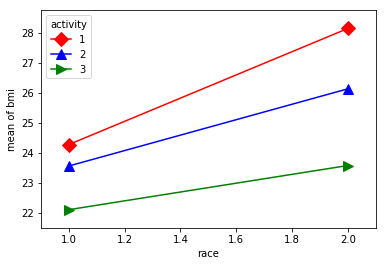

In [52]:
fig = interaction_plot(data_frame['race'], data_frame['activity'], data_frame['bmi'], colors=['r','b', 'g'], markers=['D', '^', '>'], ms=10)
plt.show()

#### 主効果　Main effects

In [56]:
# 1. interaction
f = 'bmi ~ C(race) + C(activity)'
model2 = ols(formula=f, data=data_frame)

# 2. regression
result2 = model2.fit()
print("Overall model F({:.0f},{:.0f}) = {:.3f}, p = {:.4f}".format(result2.df_model, result2.df_resid, result2.fvalue, result2.f_pvalue))
# or 
#print(result.summary())

# 3. anova_lm()による二元配置分散分析 Conduct a two-way ANOVA by anova_lm()
anova_tbl2 = sm.stats.anova_lm(result2, typ=2)
print("Two-way ANOVA table:")
print(anova_tbl2)
display(anova_table(anova_tbl2))
pval_Fert = anova_tbl2.at["C(race)", "PR(>F)"]
pval_Water = anova_tbl2.at["C(activity)", "PR(>F)"]

if pval_Fert < 0.05:
    print("Factor race DOES have an independent significant effect on the mean bmi.") 
else:
    print("Factor Fert DOESN'T have an independent significant effect on the mean bmi.") 

if pval_Water < 0.05:
    print("Factor activity DOES have an independent significant effect on the mean bmi.") 
else:
    print("Factor activity DOESN'T have an independent significant effect on the mean bmi.") 

Overall model F(3,1867) = 59.702, p = 0.0000
Two-way ANOVA table:
                   sum_sq      df          F        PR(>F)
C(race)       2768.883546     1.0  79.683770  1.025525e-18
C(activity)   2671.619408     2.0  38.442337  4.358260e-17
Residual     64875.263282  1867.0        NaN           NaN


,sum_sq,mean_sq,df,F,PR(>F),eta_sq,omega_sq
C(race),2768.883546,2768.883546,1.0,79.683770,1.025525e-18,0.039378,0.038864
C(activity),2671.619408,1335.809704,2.0,38.442337,4.358260e-17,0.037995,0.036988
Residual,64875.263282,34.748400,1867.0,NaN,NaN,NaN,NaN


Factor race DOES have an independent significant effect on the mean bmi.
Factor activity DOES have an independent significant effect on the mean bmi.


### 主効果についての結論　Conclusion for Main effects

各要因、活動レベルおよび人種は、BMI平均にわずかな影響しか及ぼさない。  
Each factor, fertilizer and water, has a small effect on the mean crop yield.

### Post-hoc Testing

In [57]:
# multiple comparison by Tukey HSD
mc_fert = mlpc.MultiComparison(data_frame['bmi'], data_frame['race'])
result_fert = mc_fert.tukeyhsd()
print(result_fert)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  1      2     2.7571  2.2117 3.3025  True 
-------------------------------------------


人種1と2の平均BMIには統計的に有意な差がある。人種1は人種2よりもBMI数値に大きな影響を及ぼす。

In [58]:
mc_water = mlpc.MultiComparison(data_frame['bmi'], data_frame['activity'])
result_water = mc_water.tukeyhsd()
print(result_water)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  1      2    -1.6087  -2.5083 -0.7092  True 
  1      3     -3.839  -4.8086 -2.8694  True 
  2      3    -2.2303  -2.9712 -1.4893  True 
---------------------------------------------


活動レベル1と2と3の平均BMIには統計的に有意な差がある。活動レベル1は、活動レベル2、３よりもBMIの数値を大きくすると考えられる。  